In [21]:
#from dask.multiprocessing import get
import numpy as np
import pandas as pd

import datetime
import urllib
 
from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict

Defining functions which will be used to build the custom data pipeline

In [22]:
def inc(x):
    return x + 1

In [23]:
def add(x,y):
    return x + y

In [24]:
def retMean(datfram,field):
    return np.mean(datfram[field])

In [25]:
def loadAPIData(queryString):
    query = (queryString)
    return pd.read_json(query)

Creating a Custom Data Pipeline. We define dependencies of targets on other targets 
as well as variables that are which are being passed as inputs to functions

In [26]:
dskTask = {
    'query1':"https://data.colorado.gov/resource/ncpu-fd8q.json",
    'field1':"admin_no",
    'query2':"https://data.colorado.gov/resource/ujff-j2yj.json",
    'field2':"acres",
    'loadWaterRight':(loadAPIData,'query1'),
    'loadFinalPermit':(loadAPIData,'query2'),
    'meanWaterRight':(retMean,'loadWaterRight','field1'),
    'meanFinalPermit':(retMean,'loadFinalPermit','field2'),
    'sum':(add,'meanWaterRight','meanFinalPermit')
}
dskTask

{'field1': 'admin_no',
 'field2': 'acres',
 'loadFinalPermit': (<function __main__.loadAPIData>, 'query2'),
 'loadWaterRight': (<function __main__.loadAPIData>, 'query1'),
 'meanFinalPermit': (<function __main__.retMean>, 'loadFinalPermit', 'field2'),
 'meanWaterRight': (<function __main__.retMean>, 'loadWaterRight', 'field1'),
 'query1': 'https://data.colorado.gov/resource/ncpu-fd8q.json',
 'query2': 'https://data.colorado.gov/resource/ujff-j2yj.json',
 'sum': (<function __main__.add>, 'meanWaterRight', 'meanFinalPermit')}

In [27]:
#dsk = {'a':1,'d':(inc,'a'),'b':(inc,'a'),'c':(add,'b','d')}

Visualizing the custom Data Pipeline

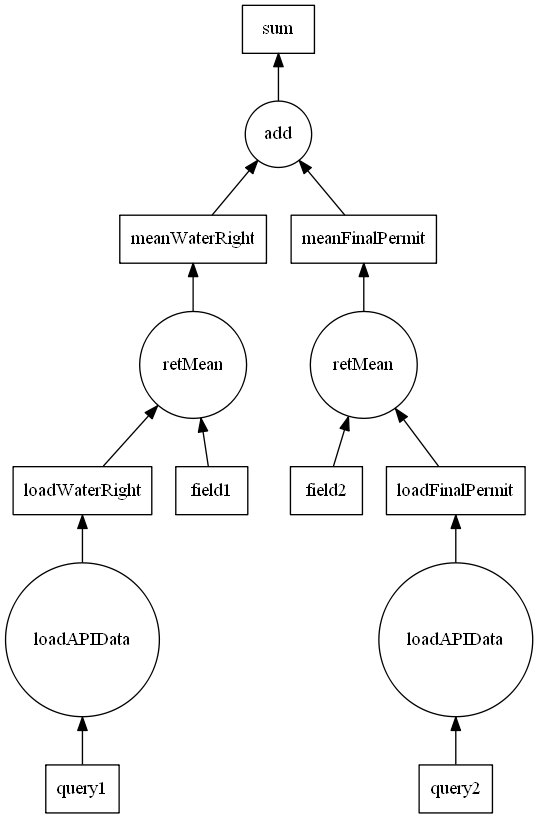

In [28]:
from dask.dot import dot_graph
dot_graph(dskTask)

The IP address and port will be that of the Dask Scheduler running on your machine

In [30]:
from dask.distributed import Client
c = Client('10.0.0.47:8786')
c.get(dskTask,'sum')

38790.14510571142

In [ ]:
#c.shutdown()

We use the get function from dask.threaded to run the dskTask on lightweight threads

In [31]:
from dask.threaded import get
get(dskTask,'sum')

38790.14510571142

We use the get function from dask.multiprocessing to run the dskTask on multiple processes

In [33]:
from dask.multiprocessing import get
get(dskTask,'sum')

38790.14510571142

The following code is to demonstrate a visual representation of how Dask Delayed creates the data pipeline

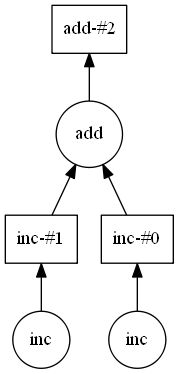

In [34]:
import dask
x = dask.delayed(inc)(1)
y = dask.delayed(inc)(2)
z = dask.delayed(add)(x, y)
z.compute()
z.visualize()

DASK collections rarely need to use the DASK 'get' method because they have this wrapped in the 'compute' method.

In [36]:
import dask.multiprocessing
import dask.array as da
arr = da.from_array(np.ones(100000),chunks=1000)
dask.set_options(get=dask.multiprocessing.get)
arr.sum().compute()

100000.0

In [37]:
import dask.dataframe as dd
query = ("https://data.colorado.gov/resource/ncpu-fd8q.json")
dd = dask.dataframe.from_pandas(data=pd.read_json(query),chunksize=100)
dd.mean().compute()

:@computed_region_nku6_53ud    7.805811e+02
admin_no                       3.862200e+04
associated_wdid                1.622933e+06
coordsew                       1.386628e+03
coordsns                       1.490827e+03
decreed_uses                   0.000000e+00
div                            2.465000e+00
max_decreed_rate               7.930993e+01
order_no                       3.230000e-01
plan_wdid                      4.441557e+06
section                        1.886519e+01
total_volumetric_limit         1.359200e+03
utm_x                          4.032329e+05
utm_y                          4.349856e+06
wd                             2.721400e+01
wdid                           2.723221e+06
dtype: float64

Visualizing how Collections process the data using the native parallel processing scheduler of dask

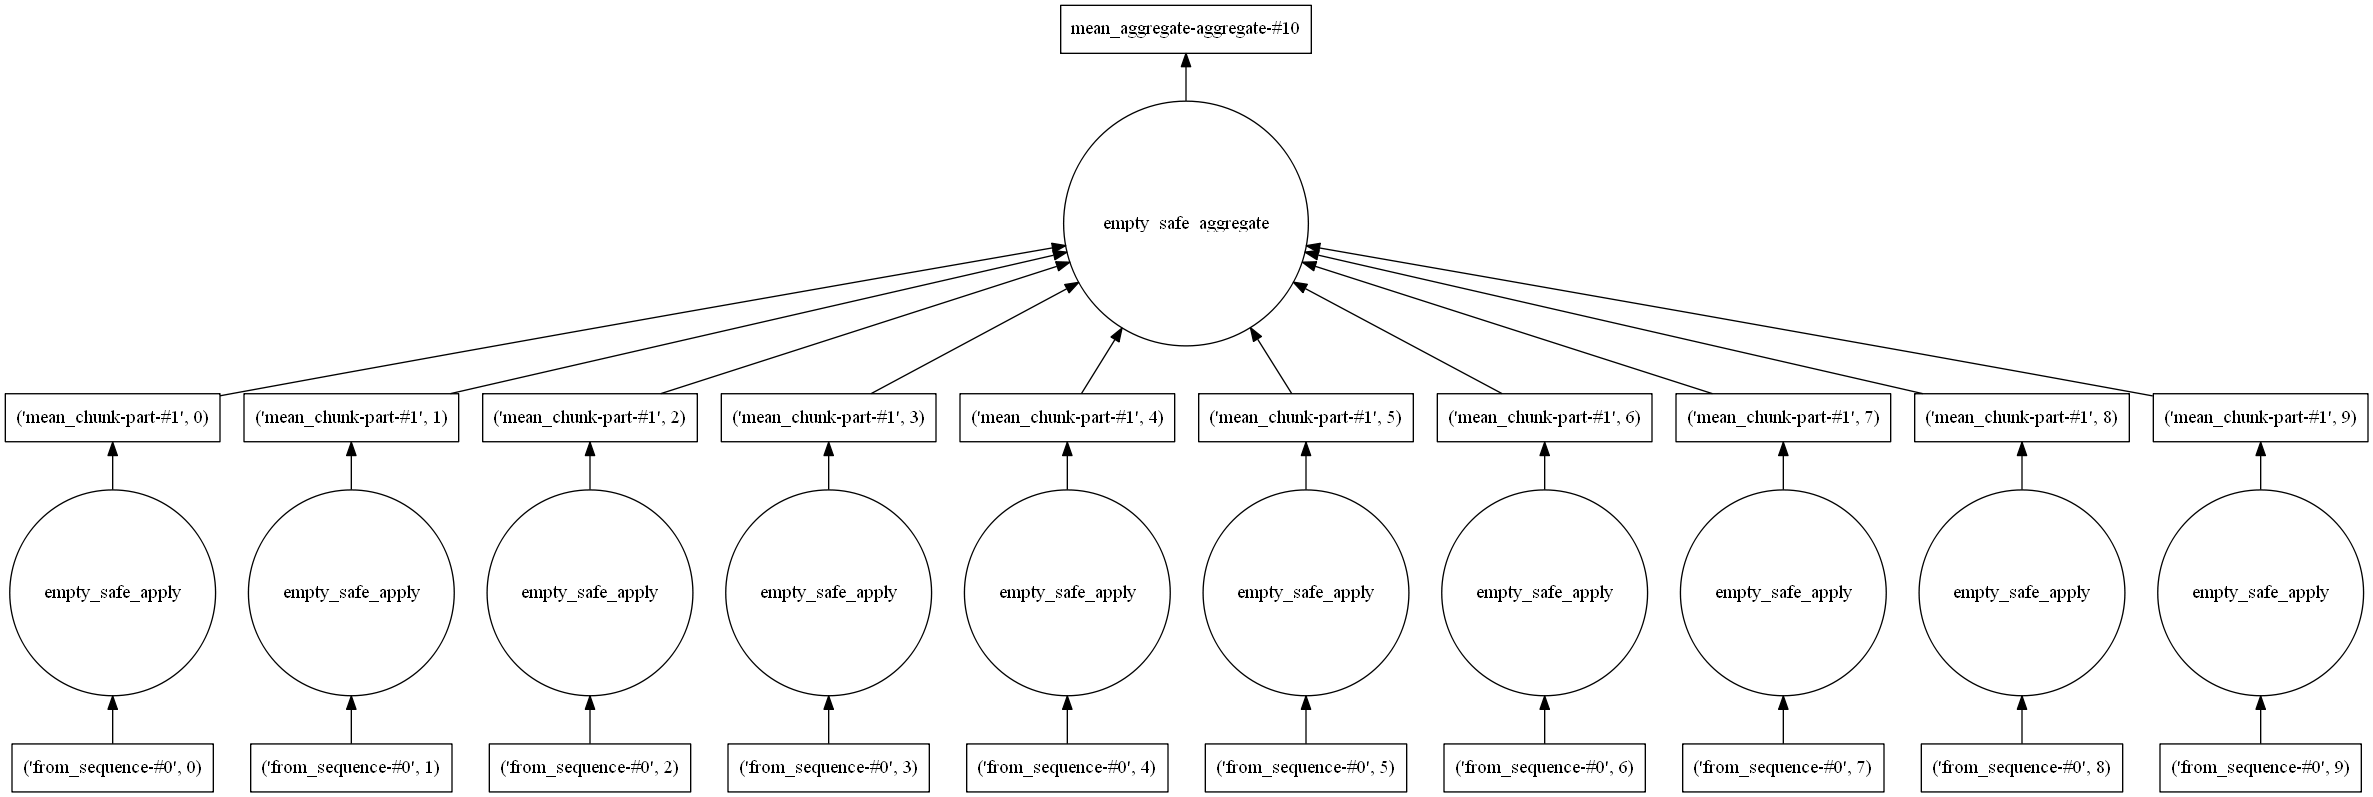

In [38]:
import dask.bag as db
b = db.from_sequence(np.arange(1,150000,2),npartitions = 10)
b.mean().visualize()

In [39]:
b.mean().compute()

75000.0